# Epsilon-Greedy Bandit Algorithm
widely used strategies for balancing exploration and exploitation in multi-armed bandit problems. It provides an elegant solution to the fundamental trade-off: should we exploit what we know works well, or explore to discover potentially better options?
Watch video form 23:32-31:00

In [4]:

from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/aQJP3Z2Ho8U?start=1380', width=800, height=450)

## Installation
First, install the required dependencies with pinned versions for reproducibility.

In [ ]:
% capture
!pip install numpy==1.24.3 matplotlib==3.7.2

UsageError: Cell magic `%%` not found.


## Overview

The **Epsilon-Greedy** algorithm is one of the simplest and most widely used strategies for balancing exploration and exploitation in multi-armed bandit problems. It provides an elegant solution to the fundamental trade-off: should we exploit what we know works well, or explore to discover potentially better options?

### The Exploration-Exploitation Dilemma

In reinforcement learning, we face a constant dilemma:
- **Exploitation**: Choose the action that currently appears best based on our estimates
- **Exploration**: Try other actions to gather more information and potentially discover better options

Pure exploitation can lead to suboptimal behavior if our initial estimates are wrong. Pure exploration wastes opportunities by not leveraging what we've learned. Epsilon-greedy provides a simple probabilistic solution.

### How It Works

At each time step $t$, the algorithm:
- With probability $\epsilon$: **Explores** by choosing a random action (excluding the current best to ensure true exploration)
- With probability $1-\epsilon$: **Exploits** by choosing the action with the highest estimated value $Q_t(a)$

This means that if $\epsilon = 0.1$, the agent will explore 10% of the time and exploit 90% of the time.

### Action Selection Rule

The action selection at time $t$ follows:

$
A_t =
\begin{cases}
\
\text{random action} \neq \arg\max_a Q_t(a)
& \text{with probability } \dfrac{\epsilon}{|\mathcal A|} \\[8pt]
\arg\max_a Q_t(a)
& \text{with probability } (1-\epsilon) + \dfrac{\epsilon}{|\mathcal A|}
\end{cases}
$


### Policy

A **policy** defines the behavior of an agent by specifying the probability of selecting each action at a given time step. 

In reinforcement learning, the policy is important because it determines how the agent balances **exploration** and **exploitation**. Exploration allows the agent to try different actions in order to learn about their consequences, while exploitation focuses on selecting the action that currently has the highest estimated value. A well-designed policy ensures sufficient exploration while still favoring actions that are believed to be optimal.

For the $epsilon$-greedy method, the policy is defined as:

$$
\pi_t(a) =
\begin{cases}
(1-\epsilon) + \dfrac{\epsilon}{|\mathcal A|}
& \text{if } a \in \arg\max_{a'} Q_t(a') \\[10pt]
\dfrac{\epsilon}{|\mathcal A|}
& \text{otherwise}.
\end{cases}
$$

This policy ensures that the greedy action is selected most of the time, while all actions have a nonzero probability of being chosen. As a result, the agent continues to explore the action space and reduces the risk of converging prematurely to a suboptimal policy.








Where $Q_t(a)$ represents our current estimate of the value of action $a$.

### Value Update Rule

The action-value estimates are updated using incremental sample averaging:

$$Q_{t+1}(a) = Q_t(a) + \frac{1}{N_t(a)}\left[R_t - Q_t(a)\right]$$

This can be rewritten as:

$$Q_{t+1}(a) = Q_t(a) + \alpha_t(a) \left[R_t - Q_t(a)\right]$$

where $\alpha_t(a) = \frac{1}{N_t(a)}$ is the step size.

**Interpretation:**
- $Q_t(a)$: Current estimate of action $a$'s value
- $N_t(a)$: Number of times action $a$ has been selected (ensures we average over all samples)
- $R_t$: Reward received from the most recent selection
- $R_t - Q_t(a)$: Prediction error (how much we were wrong)

### Algorithm Parameters

- **`epsilon` ($\epsilon$)**: Exploration rate, typically between 0.01 and 0.1
  - Smaller values: More exploitation, faster convergence but risk of suboptimal solution
  - Larger values: More exploration, slower convergence but better chance of finding optimal action
  
- **`initial_q`**: Initial Q-value estimates
  - Setting high initial values encourages early exploration ("optimistic initialization")
  - Setting to zero is neutral
  
- **`alfa` ($\alpha$)**: Optional fixed step size
  - If `None`: Uses sample average (decreasing step size $1/N_t(a)$)
  - If fixed: Constant step size, gives more weight to recent rewards (useful for non-stationary problems)

### Advantages and Limitations

**Advantages:**
- Simple to implement and understand
- Computationally efficient
- Guaranteed to explore all actions infinitely often
- Works well in practice for many problems

**Limitations:**
- Explores uniformly at random (doesn't prioritize promising actions)
- Fixed $\epsilon$ doesn't adapt over time
- May waste time on obviously bad actions
- No uncertainty modeling

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from deepmind_bandits import EpsilonGreedyAlgorithm, GaussianBandits, BanditDataAnalyzer

# Set random seed for reproducibility
np.random.seed(42)

## Environment Setup

We create a Gaussian bandit environment with 4 actions. Each action has a true mean reward (unknown to the agent) and some noise (standard deviation).

**Environment Design:**
- Action 0: Low mean (1.0), low noise - consistently mediocre
- Action 1: High mean (2.0), moderate noise - **optimal action**
- Action 2: Negative mean (-1.0), low noise - clearly bad
- Action 3: Zero mean (0.0), high noise - unpredictable

The agent must learn through interaction which action is best.

In [7]:
# Create bandit environment with Gaussian reward distributions
means = [1.0, 2.0, -1.0, 0.0]
stds = [0.1, 0.2, 0.1, 0.3]
env = GaussianBandits(means, stds)
num_actions = env.num_arms

print(f"Number of actions: {num_actions}")
print(f"True mean rewards: {means}")
print(f"Reward noise (stds): {stds}")
print(f"\nOptimal action: {np.argmax(means)} with mean reward = {max(means):.2f}")
print(f"\nGoal: Learn to select action {np.argmax(means)} most often through trial and error!")

Number of actions: 4
True mean rewards: [1.0, 2.0, -1.0, 0.0]
Reward noise (stds): [0.1, 0.2, 0.1, 0.3]

Optimal action: 1 with mean reward = 2.00

Goal: Learn to select action 1 most often through trial and error!


## Agent Initialization

We create an epsilon-greedy agent and a data analyzer to track its performance over time.

**Agent Configuration:**
- All Q-values initialized to 0 (neutral, no initial bias)
- Exploration rate $\epsilon = 0.1$ (10% random exploration)
- Uses sample-average updates (step size = 1/N)

**Analyzer:**
- Tracks rewards, actions, and regret at each step
- Computes cumulative metrics
- Generates visualization plots

In [8]:
# Create epsilon-greedy agent
agent = EpsilonGreedyAlgorithm(num_actions=num_actions, initial_q=0.0)
agent.epsilon = 0.1  # 10% exploration rate

# Create analyzer for tracking performance metrics
analyzer = BanditDataAnalyzer(means, num_actions)

print(f"Agent Configuration:")
print(f"  Epsilon (exploration rate): {agent.epsilon}")
print(f"  Initial Q-values: {agent.Q}")
print(f"  Initial action counts: {agent.N}")
print(f"\nThe agent starts with no knowledge - all Q-values are 0!")

Agent Configuration:
  Epsilon (exploration rate): 0.1
  Initial Q-values: [0. 0. 0. 0.]
  Initial action counts: [0 0 0 0]

The agent starts with no knowledge - all Q-values are 0!


## Training Loop

Now we run the main learning loop for 1000 time steps. At each step:

1. **Select**: Agent chooses action using epsilon-greedy policy
2. **Execute**: Action is taken in environment, reward is observed
3. **Update**: Q-value estimate is updated based on observed reward
4. **Track**: Performance metrics are recorded

Over time, the agent should:
- Build accurate estimates of each action's value
- Increasingly select the optimal action (action 1)
- Minimize cumulative regret

In [9]:
T = 1000  # Number of time steps

for t in range(T):
    # Agent selects action using epsilon-greedy policy
    action = agent.select_action_greedy()
    
    # Execute action and observe reward from environment
    reward = env.pull_arm(action)
    
    # Update agent's Q-value estimates
    agent.update_values(action, reward)
    
    # Track performance for analysis
    analyzer.update_and_analyze(action, reward)

print(f"Training completed: {T} time steps\n")
print(f"Final Q-value estimates:")
for a in range(num_actions):
    error = abs(agent.Q[a] - means[a])
    print(f"  Action {a}: Q = {agent.Q[a]:.3f} (true = {means[a]:.2f}, error = {error:.3f})")
    
print(f"\nAction selection counts: {agent.N}")
print(f"Total selections: {sum(agent.N)} (should equal {T})")

Training completed: 1000 time steps

Final Q-value estimates:
  Action 0: Q = 1.003 (true = 1.00, error = 0.003)
  Action 1: Q = 2.011 (true = 2.00, error = 0.011)
  Action 2: Q = -1.010 (true = -1.00, error = 0.010)
  Action 3: Q = 0.048 (true = 0.00, error = 0.048)

Action selection counts: [ 75 849  38  38]
Total selections: 1000 (should equal 1000)


## Results Analysis

Let's analyze how well the epsilon-greedy agent performed. We'll look at:
- **Q-value convergence**: Did estimates converge to true values?
- **Action selection**: Did we find and exploit the optimal action?
- **Regret**: How much reward did we lose by not always picking optimally?
- **Cumulative reward**: Total reward accumulated over time

In [10]:
# Finalize analysis (compute cumulative metrics)
analyzer.finalize_analysis()

### Q-Value Progression Over Time

This plot shows how the agent's Q-value estimates evolved during learning:
- **Solid colored lines**: Q-values for each action over time
- **Dashed lines**: True mean rewards (ground truth)
- **Red arrows**: When the agent switches between actions

**What to look for:**
- Q-values should converge toward the true means (dashed lines)
- More frequently selected actions have smoother estimates
- Early exploration causes more switching (red arrows)


We observe that the value converges to the optimal action, Action 1, since it has the highest value. However, we also see that the action occasionally changes. This occurs due to exploration, where actions are randomly selected to ensure continued exploration of the action space.

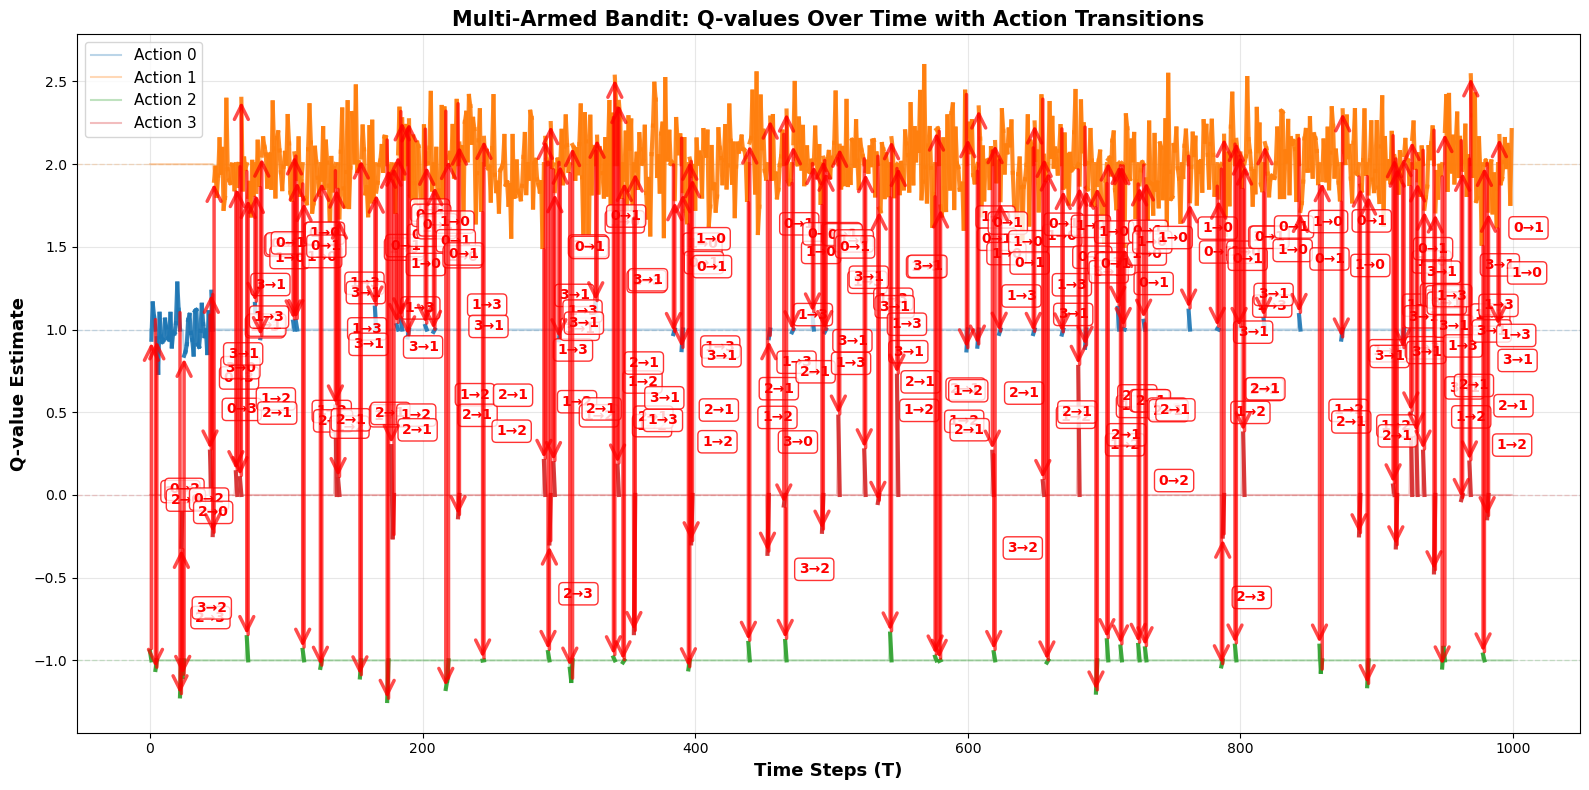


Transitions detected: 203
  Step 1: Action 2 → Action 0
  Step 4: Action 0 → Action 2
  Step 5: Action 2 → Action 0
  Step 22: Action 0 → Action 2
  Step 23: Action 2 → Action 3
  Step 24: Action 3 → Action 2
  Step 25: Action 2 → Action 0
  Step 44: Action 0 → Action 3
  Step 45: Action 3 → Action 0
  Step 46: Action 0 → Action 3
  Step 47: Action 3 → Action 1
  Step 63: Action 1 → Action 3
  Step 64: Action 3 → Action 1
  Step 66: Action 1 → Action 3
  Step 67: Action 3 → Action 1
  Step 71: Action 1 → Action 2
  Step 72: Action 2 → Action 1
  Step 77: Action 1 → Action 0
  Step 78: Action 0 → Action 1
  Step 81: Action 1 → Action 0
  Step 82: Action 0 → Action 1
  Step 105: Action 1 → Action 0
  Step 106: Action 0 → Action 1
  Step 107: Action 1 → Action 0
  Step 108: Action 0 → Action 1
  Step 112: Action 1 → Action 2
  Step 113: Action 2 → Action 1
  Step 125: Action 1 → Action 2
  Step 126: Action 2 → Action 1
  Step 136: Action 1 → Action 3
  Step 137: Action 3 → Action 1
  Ste

In [12]:
analyzer.plot_Qvalue()

### Cumulative Regret

**Regret** measures the difference between the reward we *could* have gotten (always picking optimal) and what we *actually* got.

At each step $t$:
- Instantaneous regret = $r^* - r_t$ where $r^*$ is the optimal mean reward
- Cumulative regret = sum of all instantaneous regrets up to time $t$

**What to look for:**
- **Slope**: Should decrease over time as we learn
- **Final value**: Lower is better (less total regret)
- **Shape**: Linear growth means we're not learning; sublinear (flattening) means we're improving

For epsilon-greedy, regret grows *linearly* in the long run because we always explore with probability $\epsilon$.

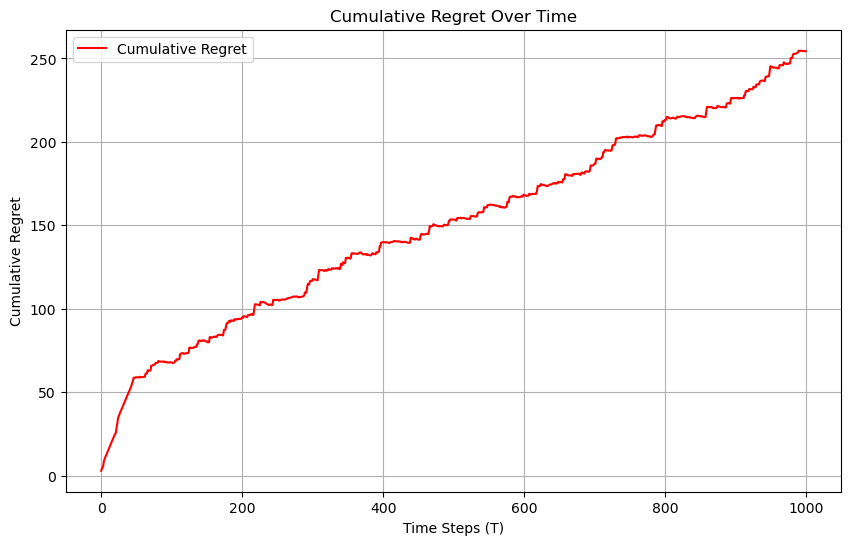

In [13]:
analyzer.plot_regret()

### Cumulative Reward

This shows the total reward accumulated over time:
- **Black line**: Total cumulative reward across all actions
- **Dashed lines**: Cumulative reward per action

**What to look for:**
- Steeper slope = higher reward rate
- The optimal action's line should dominate
- Total reward should increase steadily

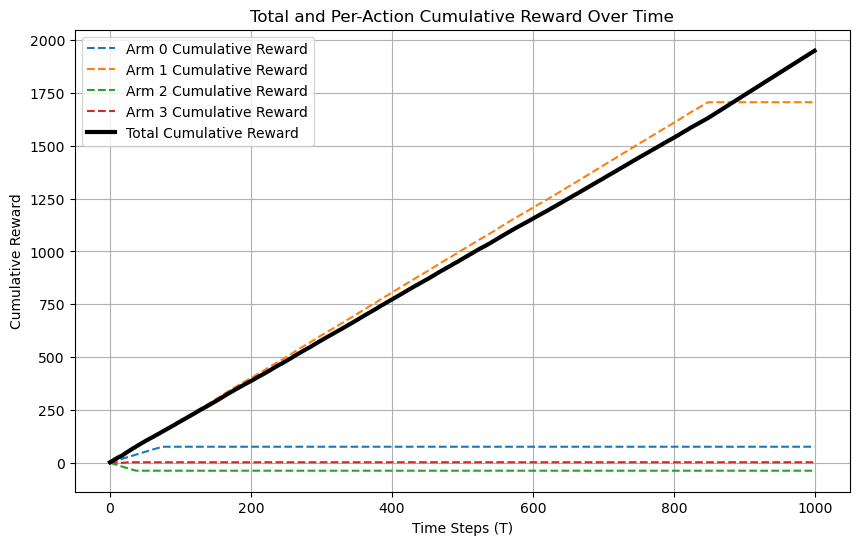

In [14]:
analyzer.plot_cumulative_reward()

## Performance Summary and Analysis

Let's quantify how well the agent learned:

In [15]:
print("=" * 60)
print("EPSILON-GREEDY PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\nExperiment Parameters:")
print(f"  Total time steps: {T}")
print(f"  Exploration rate (epsilon): {agent.epsilon}")
print(f"  Expected exploration steps: ~{int(T * agent.epsilon)} ({agent.epsilon * 100:.0f}%)")

print(f"\nLearned Q-Values vs True Means:")
for a in range(num_actions):
    q_val = agent.Q[a]
    true_mean = means[a]
    error = abs(q_val - true_mean)
    count = agent.N[a]
    pct = 100 * count / T
    marker = " ← OPTIMAL" if a == np.argmax(means) else ""
    print(f"  Action {a}: Q={q_val:6.3f}, True={true_mean:5.2f}, Error={error:.3f} | "
          f"Selected {count:4d} times ({pct:5.1f}%){marker}")

optimal_action = np.argmax(means)
optimal_selections = agent.N[optimal_action]
optimal_pct = 100 * optimal_selections / T

print(f"\nOptimal Action Performance:")
print(f"  Optimal action: {optimal_action} (true mean = {means[optimal_action]:.2f})")
print(f"  Times selected: {optimal_selections}/{T} ({optimal_pct:.1f}%)")
print(f"  Theoretical maximum (1-ε): {100*(1-agent.epsilon):.1f}%")

if optimal_pct >= 100 * (1 - agent.epsilon) - 5:  # within 5% of theoretical max
    print(f"  ✓ Successfully learned to exploit optimal action!")
else:
    print(f"  ⚠ Could improve - not yet converged to optimal policy")

print(f"\nRegret Analysis:")
print(f"  Final cumulative regret: {analyzer.regret[-1]:.2f}")
print(f"  Average regret per step: {analyzer.regret[-1]/T:.3f}")
expected_regret_rate = agent.epsilon * (means[optimal_action] - np.mean(means))
print(f"  Theoretical regret rate: ~{expected_regret_rate:.3f} per step")

print("\n" + "=" * 60)

EPSILON-GREEDY PERFORMANCE SUMMARY

Experiment Parameters:
  Total time steps: 1000
  Exploration rate (epsilon): 0.1
  Expected exploration steps: ~100 (10%)

Learned Q-Values vs True Means:
  Action 0: Q= 1.003, True= 1.00, Error=0.003 | Selected   75 times (  7.5%)
  Action 1: Q= 2.011, True= 2.00, Error=0.011 | Selected  849 times ( 84.9%) ← OPTIMAL
  Action 2: Q=-1.010, True=-1.00, Error=0.010 | Selected   38 times (  3.8%)
  Action 3: Q= 0.048, True= 0.00, Error=0.048 | Selected   38 times (  3.8%)

Optimal Action Performance:
  Optimal action: 1 (true mean = 2.00)
  Times selected: 849/1000 (84.9%)
  Theoretical maximum (1-ε): 90.0%
  ⚠ Could improve - not yet converged to optimal policy

Regret Analysis:
  Final cumulative regret: 254.35
  Average regret per step: 0.254
  Theoretical regret rate: ~0.150 per step



## Key Takeaways

**What we learned:**
1. ✅ Epsilon-greedy successfully balances exploration and exploitation
2. ✅ Q-value estimates converge to true means with enough samples  
3. ✅ The optimal action is identified and selected most often
4. ⚠️ Continuous exploration (fixed $\epsilon$) causes linear regret growth

**Improvements to consider:**
- **Decaying epsilon**: Reduce $\epsilon$ over time (e.g., $\epsilon_t = \epsilon_0/t$)
- **Optimistic initialization**: Start with high Q-values to encourage early exploration
- **UCB**: Use uncertainty-based exploration instead of random
- **Thompson Sampling**: Bayesian approach that naturally balances exploration/exploitation

**When to use epsilon-greedy:**
- Simple baseline for bandit problems
- When computational efficiency matters
- When you want interpretable, predictable behavior
- As a starting point before trying more sophisticated methods



## Exercises


### Exercise 1: Experiment with Different Reward Distributions

Try modifying the bandit environment with different reward distributions. How does the epsilon-greedy algorithm perform when the optimal action has high variance?

Modify the `means` and `stds` arrays and re-run the training loop to observe the behavior.



<details>
    <summary>Click here for hint</summary>

```python
# High variance optimal action
means_high_var = [1.0, 2.5, 1.2, 0.5]
stds_high_var = [0.1, 1.5, 0.1, 0.1]  # Optimal action has high noise!

# Create new environment
env_new = GaussianBandits(means_high_var, stds_high_var)

# Reset and retrain agent
agent_new = EpsilonGreedyAlgorithm(num_actions=len(means_high_var), initial_q=0.0)
agent_new.epsilon = 0.1
analyzer_new = BanditDataAnalyzer(means_high_var, len(means_high_var))

# Run training loop
for t in range(1000):
    action = agent_new.select_action_greedy()
    reward = env_new.pull_arm(action)
    agent_new.update_values(action, reward)
    analyzer_new.update_and_analyze(action, reward)

# Analyze results
analyzer_new.finalize_analysis()
analyzer_new.plot_Qvalue()
analyzer_new.plot_regret()
</details>

Created by Joseph Santacalo.
Licensed under Creative Commons Attribution (CC BY). Free to share and adapt with attribution.